# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.autograd import Variable
import torch
import torchvision

## Carregamento dos dados do MNIST

In [23]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [24]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [25]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

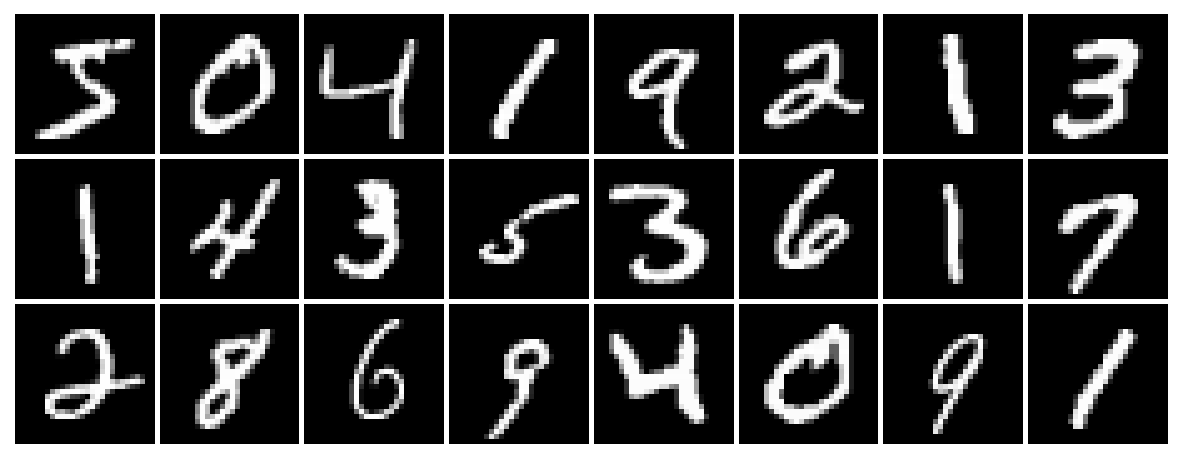

In [26]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


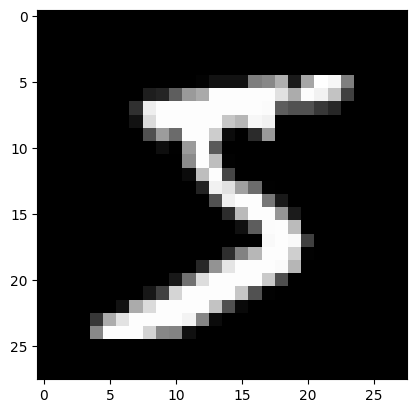

In [27]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

## Modelo

In [28]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [29]:
## TODO
model(x_train[:5].view(-1,28*28))

tensor([[ 0.2666, -0.2839, -0.1111, -0.0850, -0.0496,  0.0447, -0.3379,  0.1219,
         -0.0909,  0.1133],
        [ 0.1454, -0.2125, -0.1227, -0.0133,  0.1252,  0.1470, -0.2625,  0.0124,
         -0.0704,  0.0048],
        [ 0.3575,  0.0616, -0.0420,  0.1804, -0.0552, -0.0887, -0.0933,  0.1240,
          0.0238,  0.1043],
        [-0.0819, -0.0178, -0.3164,  0.2842,  0.1686, -0.0444, -0.1029, -0.0294,
         -0.3042,  0.0914],
        [-0.0286,  0.0790, -0.1480,  0.1683, -0.2938,  0.1112, -0.1371,  0.1507,
         -0.3394,  0.0784]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [30]:
epochs = 5
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [31]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-_3xmftbp
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-_3xmftbp
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done


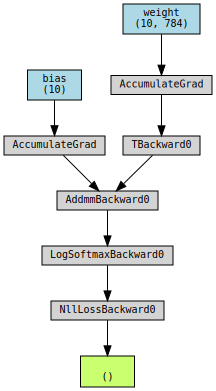

In [32]:
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
from torchviz import make_dot, make_dot_from_trace
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [33]:
from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

except KeyboardInterrupt:
    pass

<Figure size 1800x600 with 0 Axes>

In [34]:
model.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [35]:
print('Final loss:', loss.data)

Final loss: tensor(1.0978)


### Visualizando gráfico de perda durante o treinamento

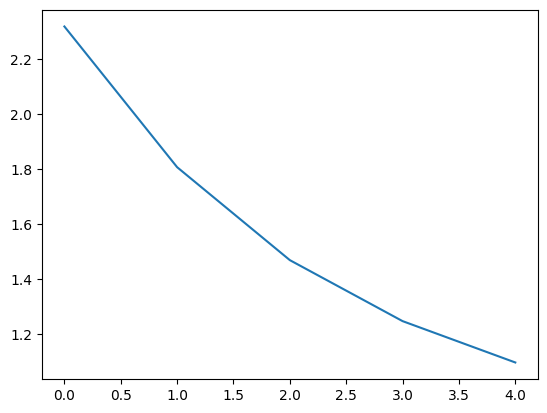

In [36]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [37]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.833


### Matriz de confusão com dados de treinamento e teste

In [38]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,93,0,4,1,0,2,2,1,0,2
1,0,109,11,1,1,2,2,6,7,1
2,2,0,75,1,1,3,1,1,2,0
3,0,0,0,79,0,13,0,0,5,2
4,0,0,1,0,92,5,3,2,0,7
5,0,2,1,1,1,56,0,0,5,2
6,2,1,1,1,3,3,86,0,0,1
7,0,1,4,4,1,1,0,104,0,9
8,0,3,1,1,0,5,0,0,65,2


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


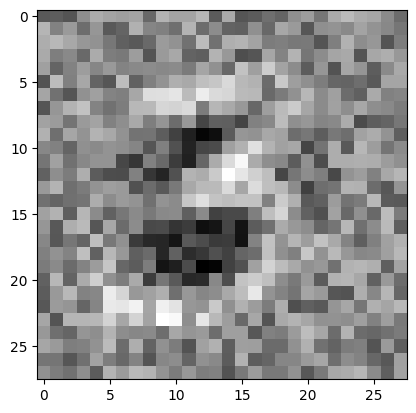

In [39]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

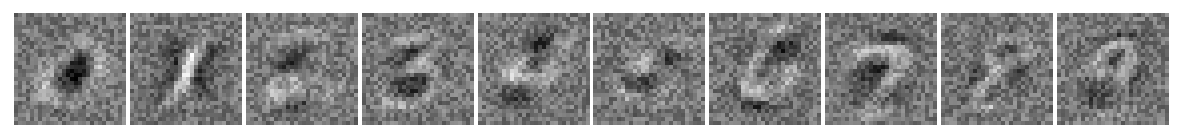

In [40]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

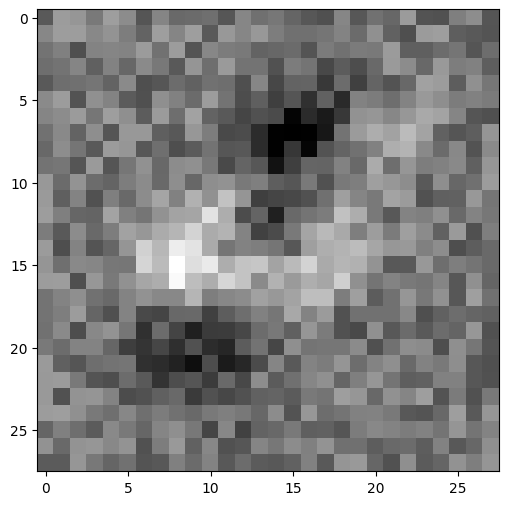

Accuracy: 0.833
epoca: 1
perda: 0.9903125


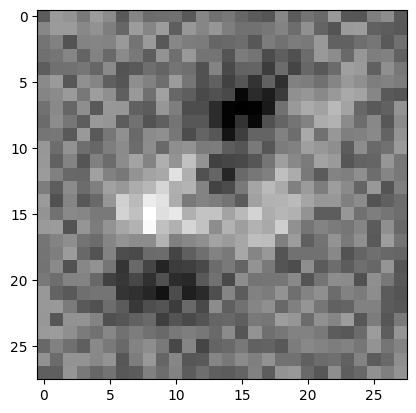

Accuracy: 0.831
epoca: 2
perda: 0.9101047


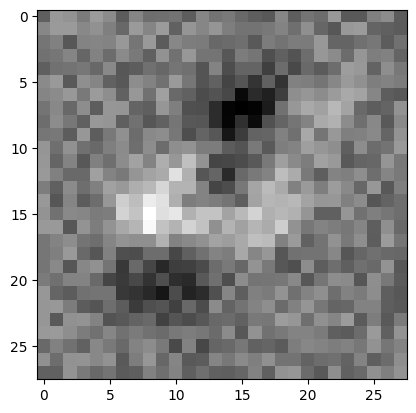

Accuracy: 0.842
epoca: 3
perda: 0.84771645


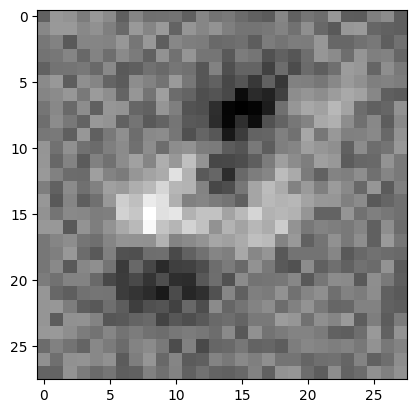

Accuracy: 0.848
epoca: 4
perda: 0.7976148


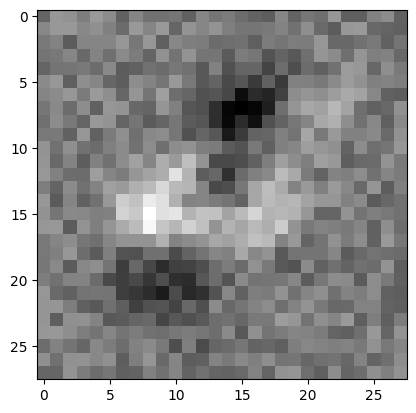

Accuracy: 0.855
epoca: 5
perda: 0.7563077


In [41]:
from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)

        # Visualizando pesos da classe 4
        plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
        plt.show()

        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

        print('Accuracy:', accuracy)
        print("epoca: " + str(i + 1))
        print("perda: " + str(loss.data.detach().numpy()))

except KeyboardInterrupt:
    pass

<details>
<summary>Mostrar Resultado</summary>

```python
from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        weights_d = model.weight.data[4].numpy().reshape(28,28)
        weights_g = model.weight.grad.data[4].numpy().reshape(28,28)
        ww = np.concatenate((weights_d,weights_g),1)
        plt.imshow(ww.reshape((28,28*2)),cmap = 'gray')
        display.display(fig)
        display.clear_output(wait=True)
        input(i)
        
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()
        print('Accuracy:', accuracy)
        print("epoca: " + str(i + 1))
        print("perda: " + str(loss.data.detach().numpy()))
except KeyboardInterrupt:
    pass
```

</details>



## Perguntas

1. Qual é o shape da matriz de entrada na rede?
2. Qual é o shape da saída da rede?
3. Qual é o número total de parâmetros da rede, incluindo o bias?

1. (1000. 28 * 28) (número de pixels)
2. (1000. 10) (pois os numeros possíveis vão de 0 a 9)
3. 28*28+10

# Aprendizados
